In [1]:
from numpy.matrixlib.defmatrix import matrix
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import VITAE
from VITAE.utils import load_data
import tensorflow as tf
import random
import os
from matplotlib import pyplot as plt


def create_heatmap_matrix(pi):
    """Create heatmap matrix
    @pi: numpy array contains pi weights"""
    matrix = np.zeros((5, 5))
    matrix[np.triu_indices(5)] = pi
    mask = np.tril(np.ones_like(matrix), k=-1)
    return matrix, mask


def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

In [6]:
data = load_data("./data/", file_name="dentate_withdays")
labels = pd.DataFrame({'Grouping': data['grouping']}, index = data['cell_ids'])
labels['Grouping'] = labels['Grouping'].astype("category")
genes = pd.DataFrame({'gene_names': data['gene_names']}, index = data['gene_names'])
dd = sc.AnnData(X = data['count'].copy(), obs = labels, var = genes)
dd.layers['counts'] = dd.X.copy()
dd.obs['days'] = data['covariates']
dd.obs['days2'] = data['covariates']

In [7]:
dd.obs[['days', 'days2']].to_numpy()

array([[24., 24.],
       [16., 16.],
       [12., 12.],
       ...,
       [24., 24.],
       [16., 16.],
       [24., 24.]])

102/200 [==============>...............] - ETA: 19sBest Epoch: 90. Best Metric: 41.227119.
Early stopping.
Pretrain Done.
Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.
Calculate UMAP ...


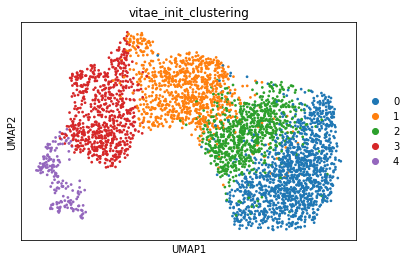

Warmup:0
 76/200 [==========>...................] - ETA: 43sBest Epoch: 64. Best Metric: 70.004776.
Early stopping.
Training Done!
Computing posterior estimations over mini-batches.
126/126 [==============================] - 3s 20ms/step
New clustering labels saved as 'vitae_new_clustering' in self.adata.obs.


In [2]:
data = load_data("./data/", file_name="dentate_withdays")
labels = pd.DataFrame({'Grouping': data['grouping']}, index = data['cell_ids'])
labels['Grouping'] = labels['Grouping'].astype("category")
genes = pd.DataFrame({'gene_names': data['gene_names']}, index = data['gene_names'])
dd = sc.AnnData(X = data['count'].copy(), obs = labels, var = genes)
dd.layers['counts'] = dd.X.copy()
dd.obs['days'] = data['covariates']
sc.pp.normalize_total(dd, target_sum=1e4)
sc.pp.log1p(dd)
sc.pp.highly_variable_genes(dd, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(dd, max_value=10)
sc.tl.pca(dd, svd_solver='arpack')
sc.pp.neighbors(dd, n_neighbors=10, n_pcs=40)
sc.tl.leiden(dd, resolution = 0.4)
sc.tl.umap(dd)

reset_random_seeds(400)
tf.keras.backend.clear_session() 
model = VITAE.VITAE(adata = dd, pi_covariates='days', model_type = 'Gaussian')
model.pre_train() 
model.init_latent_space(cluster_label= 'leiden', res = 0.4, pilayer=True) 
model.visualize_latent(color = ['vitae_init_clustering'], method = "UMAP")
model.train()
model.posterior_estimation(batch_size=32, L=100)

Calculate UMAP ...


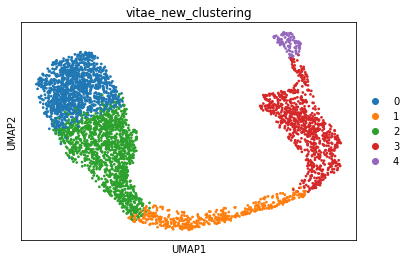

In [3]:
model.visualize_latent(color = ['vitae_new_clustering'], method = "UMAP")